In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import os
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches


from lavse.data.loaders import get_loader
from lavse.data.collate_fns import Collate
from lavse.train.evaluation import predict_loader
import torch.nn as nn

from run import load_yaml_opts, parse_loader_name
from lavse.model import model
from lavse.utils import helper
import torch

import json 
from glob import glob
from matplotlib import pyplot as plt
from pathlib import Path
import pickle 
import numpy as np
# import numpy as np
# from model import l2norm
# from evaluation import encode_data_vector

In [2]:
data_path = Path('/opt/jonatas/datasets/lavse/')
data_name = 'coco_precomp'

In [3]:
loader = get_loader(
        data_split='test',
        data_path=data_path,
        data_name=data_name,
        loader_name='precomp',
        local_rank=0,
        lang='en',
        text_repr='word',
        vocab_paths=['../.vocab_cache/coco_precomp.json'],
        ngpu=0,
        batch_size=128,
#         **opt.dataset.val,
    )
device = torch.device('cuda:0')
dataset = loader.dataset
# ids = np.loadtxt(Path(data_path)/ 'coco_precomp' / 'test_ids.txt', dtype=int)
# dataset.ids = ids
print(dataset.ids[0])

Image div 1
391895


In [4]:
path = Path('/opt/jonatas/repos/lavse/logs_aaai2/coco_precomp/adapt_t2i/simple-glove_1024-nofreeze-lr7/')
opt = load_yaml_opts(path / 'options.yaml')
model_path = path / 'best_model.pkl'


opt['model']['txt_enc']['params']['glove_path'] = '/opt/jonatas/repos/lavse/.vocab_cache/glove_coco_precomp.json.pkl'

In [5]:
# load model and options
model = model.LAVSE(**opt.model, tokenizers=loader.dataset.tokenizers)#.to(device)
checkpoint = helper.restore_checkpoint(
    path=model_path,
    model=model,
)

model.set_devices_(
    txt_devices=[device],
    img_devices=[device],
    loss_device=device,
)
is_master = True
model.master = is_master # FIXME: Replace "if print" by built_in print


In [6]:
img_embs, cap_embs, cap_lens = predict_loader(model, loader, device)
print(img_embs.shape, cap_embs.shape)

(1000, 36, 1024) (5000, 77, 1024)


In [7]:
data = None
with open(data_path / 'coco/annotations/captions_val2014.json') as fp:
    data = json.load(fp)

In [8]:
features = glob('/opt/jonatas/datasets/vqa/coco/extract_rcnn/2018-04-27_bottom-up-attention_fixed_36/*')
features = {fname.split('/')[-1][:-3]: fname for fname in features}

In [9]:
data_dict = {x['id']: x for x in data['images']}

In [10]:
for f in features:
    print(f)
    break

COCO_val2014_000000237628.jpg.


In [11]:
def get_instance(CAP_ID):
    _id = dataset.ids[CAP_ID]
    instance_info = data_dict[_id]
    img_path = instance_info['file_name']
#     print(img_path)
    feat = features[f'{img_path}.']
#     print(feat)
    f = torch.load(feat)
    bboxes = f['rois'].data.numpy().astype(np.int)
    im = plt.imread(Path(data_path) / 'coco' / 'images' / 'val2014' / instance_info['file_name'])
#     plt.imshow(im)
#     plt.title(dataset.captions[CAP_ID])
#     plt.xticks([])
#     plt.yticks([])
    return im, bboxes

In [130]:
def get_weights(model, CAP_ID):
    sim = model.similarity.similarity(
        torch.FloatTensor(img_embs[CAP_ID:CAP_ID+1]).cuda(),
        torch.FloatTensor(cap_embs[CAP_ID:CAP_ID+1]).cuda(),
        cap_lens,
    )

    weights = model.similarity.similarity.masks[0]
#     print(weights)
    weights = weights[0]
#     print(weights.shape)
#     weights = weights.sum(0)
    weights = torch.norm(weights, dim=0)
    weights = nn.ReLU()(weights)
    print(weights)
    print(weights.shape)
#     print(weights.shape)

    # weights = nn.Softmax(-1)(weights)
    weights = weights / weights.max()
    
    # w = (weights - weights.min()) / (weights.max() - weights.min())
    # w = nn.Softmax(-1)(w)
    return weights

In [131]:
def plot_img(im, bboxes, w):
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    # w = weights / weights.max()
    for bbox, _w in zip(bboxes, w):        
        plt.gca().add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=True,
                          color='white',
                          edgecolor='gray', linewidth=0, alpha=_w*0.75,)
                )
    ax.set_title(dataset.captions[CAP_ID])
    ax.set_xticks([])
    ax.set_yticks([])
    # Add the patch to the Axes
    # ax.add_patch(rect)

In [309]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [294]:
def plot_img(im, bboxes, w, cap_id=None, outpath=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(30*0.8, 7*0.8))
    plt.suptitle(dataset.captions[CAP_ID], fontsize=38)    
    
    ax[0].imshow(im)
    ax[1].imshow(im)
    ax[2].imshow(im)        
    
    w = w.data.cpu().numpy()
    # w = weights / weights.max()
    for bbox, _w in zip(bboxes, w):        
        ax[1].add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          color='white',
                          edgecolor='gray', linewidth=1, alpha=1.)
                )
        ax[2].add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=True,
                          color='white',
                          edgecolor='gray', linewidth=0, alpha=_w*0.75,)
                )    
    for _ax in ax:
        _ax.set_xticks([])
        _ax.set_yticks([])
    
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)    
    if outpath is not None:
        plt.savefig(Path(outpath) / f'{int(cap_id)}.pdf', bbox_to_inches='tight')
#         plt.savefig(outpath)
    # Add the patch to the Axes
    # ax.add_patch(rect)

tensor([52.9291, 44.3085, 16.9156, 11.6427,  6.5190, 28.0378,  6.1788,  7.4558,
         7.6642,  6.5664,  5.0499,  9.5531, 13.8501,  7.6889,  7.9298,  6.4092,
         6.0097, 10.6078, 28.3721, 18.4294,  6.6819,  7.3926, 19.6707,  6.5824,
         7.0782, 25.8854, 24.4060, 24.5812, 29.3701, 14.3080, 26.9128, 48.5089,
         8.2439, 11.7218, 13.6975,  5.5134], device='cuda:0',
       grad_fn=<ReluBackward0>)
torch.Size([36])


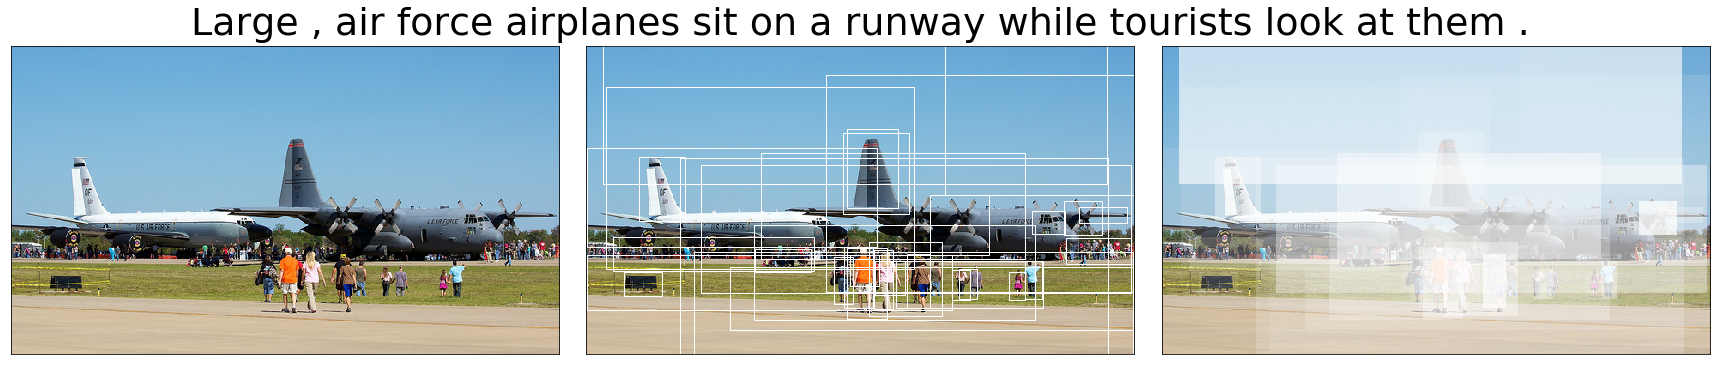

In [343]:
# CAP_ID = 110 # This one
# CAP_ID = 175 # This one
# CAP_ID = 223 # This one
# CAP_ID = 306 # This one
# CAP_ID = 628 # This one
# CAP_ID = 748 # This one
# CAP_ID = 765 # This one/
# CAP_ID = 766 # This one/
CAP_ID = 769 # This one/
im, bbox = get_instance(CAP_ID)
w = get_weights(model, CAP_ID)
# plot_img(im, bbox, cap_id=CAP_ID, w=w, outpath=None)
plot_img(im, bbox, cap_id=CAP_ID, w=w, outpath='../figures/aaai/')